# Introduction to Machine Learning Pipelines

We are going to use a sample of the well known dataset called Credit Card Fraud Detection.

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
The original dataset is available [here](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.


In [ ]:
import pandas as pd
import numpy as np
df = pd.read_csv('data/creditcard_sampledata.csv') 

Let us check the distribution of the labels inside our dataframe

In [ ]:
cases_df = df.Class.value_counts()

In [ ]:
cases_df

We have 295 positive cases out of 170884 - we are in a situation of imbalanced data, with just 0.172% of the fraudsters available in our dataset

In [ ]:
ratio_cases = cases_df/len(df.index)
print(f'Ratio of fraudulent cases: {ratio_cases[1]}\nRatio of non-fraudulent cases: {ratio_cases[0]}')

Let us separate the features from the target variable

In [ ]:
X = df.drop(['Class'], axis=1)
y = df.Class.values

In [ ]:
X.head(2)

Before moving to the fitting phase, we need to perform some preprocessing. 
In this phase, we need to be sure the datsa are consistent, namely features are expressed somehow in the same scale, and possibly further advanced analysis such as checking the presence of categorical variables, outliers, and missing values.

Let us plot the distriburion of each single variable. The snippet is provided down below here. Can you see a potential problem here?

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
df_original_melted = pd.melt(X)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(x='variable', y='value', data=df_original_melted)

Data is not in the same scale, so we need to perform some preprocessing. Since two features Time and Amount are not in the same scale as the PC, we apply a Standard Scaler to make the data more consinstent before fitting those data to a model.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled_new = scaler.fit_transform(X)
df_scaled_new = pd.DataFrame(X_scaled_new, columns=list(X))

We can easily check the result

In [ ]:
df_scaled_melted = pd.melt(df_scaled_new)
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.boxplot(x='variable', y='value', data=df_scaled_melted)

## Fitting a simple classifier with sklearn

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline

We now split the data into train and test: we need the test to validate our fitted model. Setting stratify as equal to the target varibale ensure the data is splitted homogeneously among the positive class in both train and test - so that the test set is representative of the data used to train the model.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled_new, y, test_size=0.2, random_state=0, stratify=y)

We fit a simple Logistic Regression as first instance. This is a pretty simple model, since it assumes linearity with respect to the fact that the dependent variable is linear in parameters.

In [ ]:
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

In [ ]:
predicted = model.predict(X_test)

In [ ]:
print('Classification report:\n', classification_report(y_test, predicted))

 Let's plot the confusion matrix to check how how model performed.

In [ ]:
ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='summer')
plt.show()

That's pretty good. We can extract more precise metrics on that. Indeed, we have quite good performances with this model: precision is pretty high, with a reasonable recall.

## Improving model Performances

### K-fold Cross Validation

In k-fold cross-validation, the data is divided into k folds. The model is trained on k-1 folds with one fold held back for testing. This process gets repeated to ensure each fold of the dataset gets the chance to be the held back set. Once the process is completed, we can summarize the evaluation metric using the mean or/and the standard deviation.

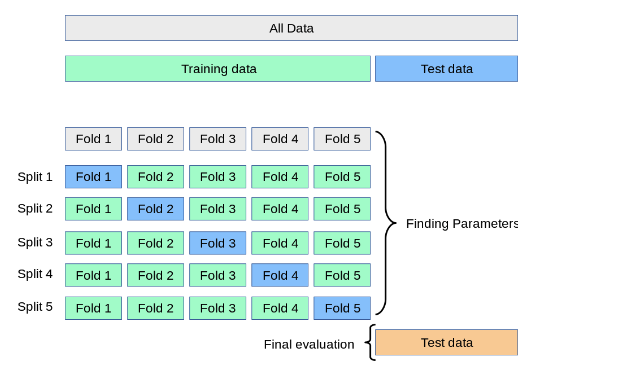

### Grid Search Cross Validation

In [ ]:
from sklearn.model_selection import GridSearchCV

Let's define the parameter sets to test, i.e. to look over to find the best model.

In [ ]:
param_grid = {
    # 'penalty': ['l1', 'l2', 'elasticnet'], 
    'C': [0.01, 0.1],
              }

Parameter C is called regularization parameter: smaller values of C specify stronger regularization. We are not going to investigate the physical meaning of the parameter itself. Just keep in mind that regularization is a statistical technique used to avoid overfitting in the model.

In [ ]:
model2 = LogisticRegression(random_state=42)
CV_model = GridSearchCV(
    estimator=model2, 
    param_grid=param_grid, 
    cv=5, 
    n_jobs=-1, 
    scoring='precision'
) # Set the scoring option to 'recall' to opt for recall.

In [ ]:
CV_model.fit(X_train, y_train)
CV_model.best_params_

We can extract the best model easily, as follows:

In [ ]:
best_model = CV_model.best_estimator_

In [ ]:
predicted = best_model.predict(X_test)
print('Classifcation report:\n', classification_report(y_test, predicted))

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap='summer')
plt.show()

We can even change the model. In this way, we can fit two (or more) different families of models, and then finding the best combination of parameters that gives us the best model for each family.

As an alternative of the Logistic Regression, we can employ the Random Forest: this is quite a benchmark in the literature, and we can employ it as ana alternative to the Logisitc.

Also, please note that the Random Forest is an ensamble model - in this case an ensamble of trees - and it is pretty convinent when we cannot claim the dependent variable can be obtained as a linear combiantion of the features.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

param_grid = { 
    # 'n_estimators': [500, 1000],
    # 'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,8],
    # 'criterion' :['gini', 'entropy']
}

In [ ]:
# Grid Search
cv_rf = GridSearchCV(
    estimator = RandomForestClassifier(), 
    param_grid = param_grid, 
    #scoring='precision',
    n_jobs=-1, 
    cv=5, 
)
#Fit
cv_rf.fit(X_train,y_train)

In [ ]:
best_model_rf = cv_rf.best_estimator_

In [ ]:
pred_rf=best_model_rf.predict(X_test)

In [ ]:
print('Classifcation report:\n', classification_report(y_test, pred_rf))

In [ ]:
ConfusionMatrixDisplay.from_estimator(best_model_rf, X_test, y_test, cmap='summer')
plt.show()

### End